# Python MAGIC EMT tutorial

## MAGIC (Markov Affinity-Based Graph Imputation of Cells)

- MAGIC imputes missing data values on sparse data sets, restoring the structure of the data
- It also proves dimensionality reduction and gene expression visualizations
- MAGIC can be performed on a variety of datasets
- Here, we show the effectiveness of MAGIC on epithelial-to-mesenchymal transition (EMT) data
    
Markov Affinity-based Graph Imputation of Cells (MAGIC) is an algorithm for denoising and transcript recover of single cells applied to single-cell RNA sequencing data, as described in Van Dijk D et al. (2018), Recovering Gene Interactions from Single-Cell Data Using Data Diffusion, Cell https://www.cell.com/cell/abstract/S0092-8674(18)30724-4.

This tutorial shows loading, preprocessing, MAGIC imputation and visualization of myeloid and erythroid cells in mouse bone marrow, as described by Paul et al., 2015. You can edit it yourself at https://colab.research.google.com/github/KrishnaswamyLab/MAGIC/blob/master/python/tutorial_notebooks/bonemarrow_tutorial.ipynb

### Table of Contents

<a href='#install'>Installation</a>
<br/>
<a href='#data'>Loading data</a>
<br/>
<a href='#pre'>Data preprocessing</a>
<br/>
<a href='#magic'>Running MAGIC</a>
<br/>
<a href='#genes'>Visualizing gene-gene interactions</a>
<br/>
<a href='#manifold'>Visualizing cell trajectories with PCA on MAGIC and PHATE</a>
<br/>
<a href='#postprocess'>Using MAGIC data in downstream analysis</a>


<a id="install"></a>

### Installation 

If you haven't yet installed MAGIC, we can install it directly from this Jupyter Notebook.

In [ ]:
!pip install --user magic-impute

### Importing MAGIC

Here, we'll import MAGIC along with other popular packages that will come in handy.

In [1]:
import magic
import scprep

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Matplotlib command for Jupyter notebooks only
%matplotlib inline

### Loading Data

Load your data using one of the following `scprep.io` methods: `load_csv`, `load_tsv`, `load_fcs`, `load_mtx`, `load_10x`. You can read about how to use them with `help(scprep.io.load_csv)` or on https://scprep.readthedocs.io/.


In [2]:
bmmsc_data = scprep.io.load_csv('https://github.com/KrishnaswamyLab/PHATE/raw/master/data/BMMC_myeloid.csv.gz')
bmmsc_data.head()

,0610007C21Rik;Apr3,0610007L01Rik,0610007P08Rik;Rad26l,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B22Rik,0610009D07Rik,0610009O20Rik,0610010B08Rik;Gm14434;Gm14308,...,mTPK1;Tpk1,mimp3;Igf2bp3;AK045244,mszf84;Gm14288;Gm14435;Gm8898,mt-Nd4,mt3-mmp;Mmp16,rp9,scmh1;Scmh1,slc43a2;Slc43a2,tsec-1;Tex9,tspan-3;Tspan3
W31105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
W31106,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
W31107,0,1,0,2,0,0,0,0,0,0,...,0,0,0,0,0,3,1,0,0,2
W31108,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,3,1,0,0,0
W31109,0,0,1,0,0,0,0,1,3,0,...,0,0,0,0,0,5,0,0,0,0


<a id="data"></a>

### Data Preprocessing

#### Filtering your data

After loading your data, you're going to want to determine the molecule per cell and molecule per gene cutoffs with which to filter the data, in order to remove lowly expressed genes and cells with a small library size.


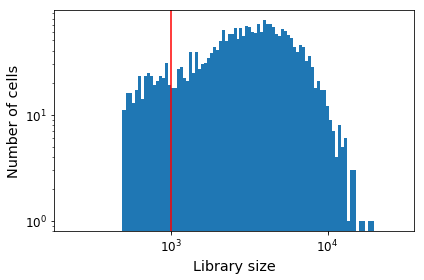

In [3]:
scprep.plot.plot_library_size(bmmsc_data, cutoff=1000)

In [4]:
bmmsc_data = scprep.filter.filter_library_size(bmmsc_data, cutoff=1000)
bmmsc_data.head()

,0610007C21Rik;Apr3,0610007L01Rik,0610007P08Rik;Rad26l,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B22Rik,0610009D07Rik,0610009O20Rik,0610010B08Rik;Gm14434;Gm14308,...,mTPK1;Tpk1,mimp3;Igf2bp3;AK045244,mszf84;Gm14288;Gm14435;Gm8898,mt-Nd4,mt3-mmp;Mmp16,rp9,scmh1;Scmh1,slc43a2;Slc43a2,tsec-1;Tex9,tspan-3;Tspan3
W31106,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
W31107,0,1,0,2,0,0,0,0,0,0,...,0,0,0,0,0,3,1,0,0,2
W31108,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,3,1,0,0,0
W31109,0,0,1,0,0,0,0,1,3,0,...,0,0,0,0,0,5,0,0,0,0
W31110,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,3,0,0,0,1


We should also remove genes that are not expressed above a certain threshold, since they are not adding anything valuable to our analysis.

In [5]:
bmmsc_data = scprep.filter.filter_rare_genes(bmmsc_data, min_cells=10)
bmmsc_data.head()

,0610007C21Rik;Apr3,0610007L01Rik,0610007P08Rik;Rad26l,0610007P14Rik,0610007P22Rik,0610009B22Rik,0610009D07Rik,0610009O20Rik,0610010F05Rik;mKIAA1841;Kiaa1841,0610010K14Rik;Rnasek,...,mKIAA1632;5430411K18Rik,mKIAA1994;Tsc22d1,mSox5L;Sox5,mTPK1;Tpk1,mimp3;Igf2bp3;AK045244,rp9,scmh1;Scmh1,slc43a2;Slc43a2,tsec-1;Tex9,tspan-3;Tspan3
W31106,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
W31107,0,1,0,2,0,0,0,0,0,3,...,0,2,0,0,0,3,1,0,0,2
W31108,0,1,0,1,0,0,0,0,0,3,...,0,0,0,0,0,3,1,0,0,0
W31109,0,0,1,0,0,0,1,3,0,8,...,0,5,0,0,0,5,0,0,0,0
W31110,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,3,0,0,0,1


#### Normalizing your data

After filtering, the next steps are to perform library size normalization and transformation. Log transformation is frequently used for single-cell RNA-seq, however, this requires the addition of a pseudocount to avoid infinite values at zero. We instead use a square root transform, which has similar properties to the log transform but has no problem with zeroes.

In [6]:
bmmsc_data = scprep.normalize.library_size_normalize(bmmsc_data)
bmmsc_data = scprep.transform.sqrt(bmmsc_data)
bmmsc_data.head()

,0610007C21Rik;Apr3,0610007L01Rik,0610007P08Rik;Rad26l,0610007P14Rik,0610007P22Rik,0610009B22Rik,0610009D07Rik,0610009O20Rik,0610010F05Rik;mKIAA1841;Kiaa1841,0610010K14Rik;Rnasek,...,mKIAA1632;5430411K18Rik,mKIAA1994;Tsc22d1,mSox5L;Sox5,mTPK1;Tpk1,mimp3;Igf2bp3;AK045244,rp9,scmh1;Scmh1,slc43a2;Slc43a2,tsec-1;Tex9,tspan-3;Tspan3
W31106,0.0,0.000000,0.0000,1.575047,0.0,0.0,0.0000,0.000000,0.0,1.575047,...,0.0,0.000000,0.0,0.0,0.0,1.575047,1.575047,0.0,0.0,0.000000
W31107,0.0,1.136584,0.0000,1.607372,0.0,0.0,0.0000,0.000000,0.0,1.968621,...,0.0,1.607372,0.0,0.0,0.0,1.968621,1.136584,0.0,0.0,1.607372
W31108,0.0,1.189802,0.0000,1.189802,0.0,0.0,0.0000,0.000000,0.0,2.060797,...,0.0,0.000000,0.0,0.0,0.0,2.060797,1.189802,0.0,0.0,0.000000
W31109,0.0,0.000000,1.0744,0.000000,0.0,0.0,1.0744,1.860915,0.0,3.038861,...,0.0,2.402431,0.0,0.0,0.0,2.402431,0.000000,0.0,0.0,0.000000
W31110,0.0,2.058031,0.0000,0.000000,0.0,0.0,0.0000,2.058031,0.0,2.058031,...,0.0,0.000000,0.0,0.0,0.0,3.564615,0.000000,0.0,0.0,2.058031


<a id="magic"></a>

### Running MAGIC

Now that your data has been preprocessed, you are ready to run MAGIC.

#### Creating the MAGIC operator

If you don't specify any parameters, the following line creates an operator with the following default values: `knn=5`, `decay=1`, `t=3`.

In [7]:
magic_op = magic.MAGIC()

#### Running MAGIC with gene selection

The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with `genes='all_genes'`.

In [8]:
bmmsc_magic = magic_op.fit_transform(bmmsc_data, genes=["Mpo", "Klf1", "Ifitm1"])
bmmsc_magic.head()

Calculating MAGIC...
  Running MAGIC on 2416 cells and 10782 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.74 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.72 seconds.
    Calculating affinities...
    Calculated affinities in 0.72 seconds.
  Calculated graph and diffusion operator in 7.34 seconds.
  Calculating imputation...
Calculated MAGIC in 7.94 seconds.


,Ifitm1,Klf1,Mpo
W31106,0.494151,0.222772,12.653059
W31107,0.041061,3.255028,3.048861
W31108,0.479306,0.343226,12.553071
W31109,0.033479,3.283794,2.841015
W31110,0.908004,0.267707,11.953947


### Visualizing gene-gene relationships
<a id="genes"></a>

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

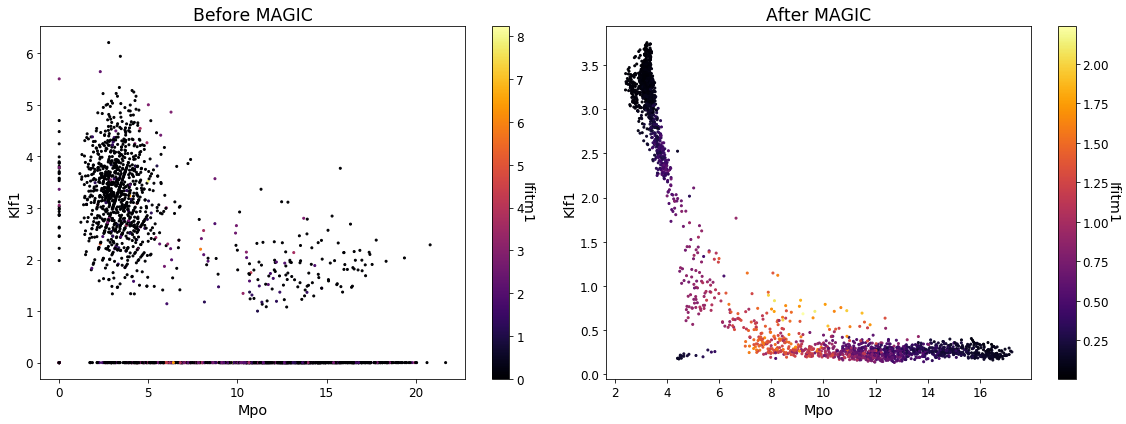

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

scprep.plot.scatter(x=bmmsc_data['Mpo'], y=bmmsc_data['Klf1'], c=bmmsc_data['Ifitm1'],  ax=ax1,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='Before MAGIC')

scprep.plot.scatter(x=bmmsc_magic['Mpo'], y=bmmsc_magic['Klf1'], c=bmmsc_magic['Ifitm1'], ax=ax2,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='After MAGIC')

plt.tight_layout()
plt.show()

The original data suffers from dropout to the point that we cannot infer anything about the gene-gene relationships. As you can see, the gene-gene relationships are much clearer after MAGIC. These relationships also match the biological progression we expect to see - Ifitm1 is a stem cell marker, Klf1 is an erythroid marker, and Mpo is a myeloid marker.

#### Setting the MAGIC operator parameters

If you wish to modify any parameters for your MAGIC operator, you change do so without having to recompute intermediate values using the `magic_op.set_params` method. Since our gene-gene relationship here appears a little too noisy, we can increase `t` a little from the default value of `3` up to a larger value like `5`.

In [10]:
magic_op.set_params(t=5)

MAGIC(a=None, decay=1, k=None, knn=5, knn_dist='euclidean', knn_max=15,
      n_jobs=1, n_pca=100, random_state=None, solver='exact', t=5, verbose=1)

We can now run MAGIC on the data again with the new parameters. Given that we have already fitted our MAGIC operator to the data, we should run the `magic_op.transform` method.

In [11]:
bmmsc_magic = magic_op.transform(genes=["Mpo", "Klf1", "Ifitm1"])
bmmsc_magic.head()

Calculating imputation...


,Ifitm1,Klf1,Mpo
W31106,0.571219,0.225925,12.462381
W31107,0.048972,3.234080,3.032480
W31108,0.488668,0.324273,12.546968
W31109,0.044142,3.250161,2.882082
W31110,0.809720,0.317691,11.736192


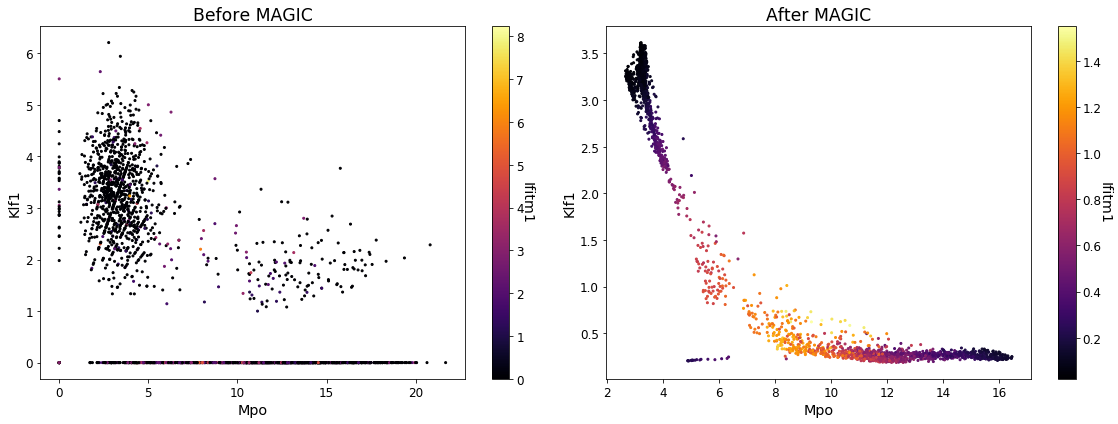

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

scprep.plot.scatter(x=bmmsc_data['Mpo'], y=bmmsc_data['Klf1'], c=bmmsc_data['Ifitm1'],  ax=ax1,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='Before MAGIC')

scprep.plot.scatter(x=bmmsc_magic['Mpo'], y=bmmsc_magic['Klf1'], c=bmmsc_magic['Ifitm1'], ax=ax2,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='After MAGIC')

plt.tight_layout()
plt.show()

That looks better. The gene-gene relationships are restored without smoothing so far as to remove structure.

<a id="manifold"></a>

### Visualizing cell trajectories with PCA on MAGIC

We can extract the principal components of the smoothed data by passing the keyword `genes='pca_only'` and use this for visualizing the data.

In [13]:
bmmsc_magic_pca = magic_op.transform(genes="pca_only")
bmmsc_magic_pca.head()

Calculating imputation...
Calculated imputation in 0.04 seconds.


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
W31106,16.575495,-2.205293,-3.173609,0.026191,3.379290,-0.328708,0.674083,-1.337519,-0.374932,0.245162,...,0.009891,-0.003240,-0.003957,-0.004786,0.004371,-0.003623,-0.004191,0.009760,-0.007117,-0.000909
W31107,-22.333830,-4.913148,-5.701725,0.174784,-1.623465,0.637437,3.213656,0.733184,2.069290,0.922711,...,0.027747,-0.005885,0.013527,0.015552,0.019255,-0.001578,0.001951,-0.024956,0.001129,0.012197
W31108,15.390584,-5.668019,-5.522961,0.227663,-2.733054,-1.363631,1.213853,-1.134904,-0.622052,2.129573,...,-0.009539,-0.013745,0.000618,0.004466,-0.000973,-0.006953,-0.000089,-0.004067,0.002934,-0.008200
W31109,-21.978137,-3.982899,-4.416052,-0.505503,-0.360550,1.144629,4.950204,0.519777,2.048395,1.303673,...,0.028121,-0.008229,0.000845,0.020816,0.016570,-0.001894,0.005415,-0.023680,0.003067,0.013028
W31110,14.850199,0.861441,-1.256983,-0.908274,-0.386235,-0.746003,0.790120,0.760150,-0.285287,0.124876,...,0.020111,0.005340,-0.026550,-0.000802,-0.016007,-0.018792,-0.010221,0.002298,-0.004076,-0.002220


We'll also perform PCA on the raw data for comparison.

In [14]:
from sklearn.decomposition import PCA
bmmsc_pca = PCA(n_components=3).fit_transform(np.array(bmmsc_data))

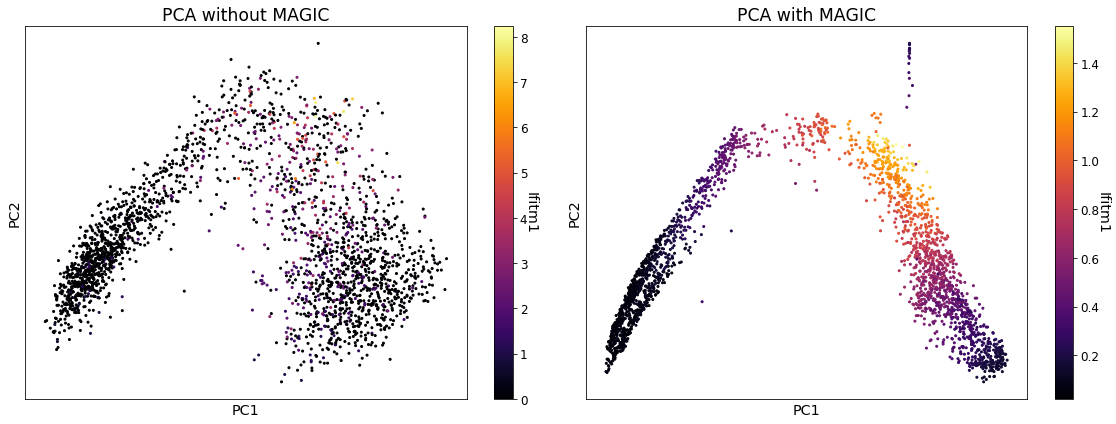

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

scprep.plot.scatter2d(bmmsc_pca, c=bmmsc_data['Ifitm1'], 
                      label_prefix="PC", title='PCA without MAGIC',
                      legend_title="Ifitm1", ax=ax1, ticks=False)

scprep.plot.scatter2d(bmmsc_magic_pca, c=bmmsc_magic['Ifitm1'], 
                      label_prefix="PC", title='PCA with MAGIC',
                      legend_title="Ifitm1", ax=ax2, ticks=False)

plt.tight_layout()
plt.show()

We can also plot this in 3D.

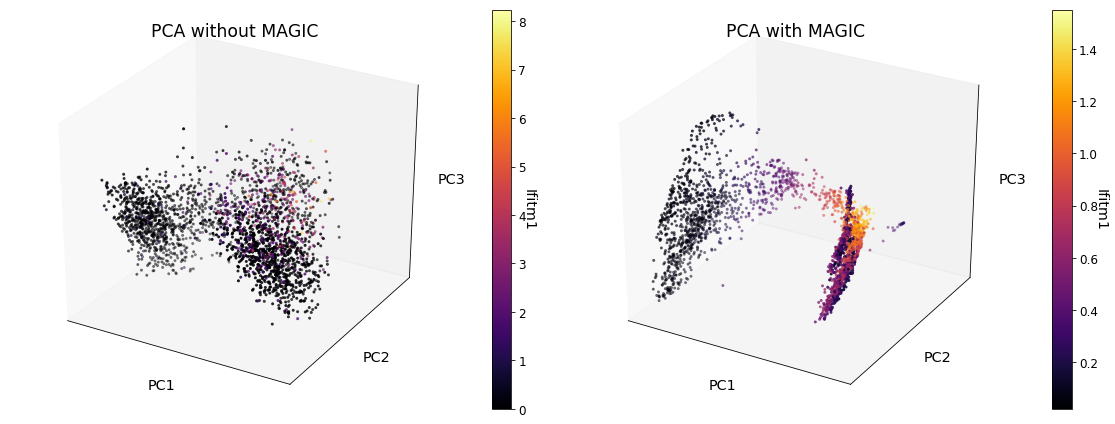

In [16]:
from mpl_toolkits.mplot3d import Axes3D

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6), subplot_kw={'projection':'3d'})

scprep.plot.scatter3d(bmmsc_pca, c=bmmsc_data['Ifitm1'], 
                      label_prefix="PC", title='PCA without MAGIC',
                      legend_title="Ifitm1", ax=ax1, ticks=False)

scprep.plot.scatter3d(bmmsc_magic_pca, c=bmmsc_magic['Ifitm1'], 
                      label_prefix="PC", title='PCA with MAGIC',
                      legend_title="Ifitm1", ax=ax2, ticks=False)

plt.tight_layout()
plt.show()

### Visualizing MAGIC values with PHATE

In complex systems, two dimensions of PCA are not sufficient to view the entire space. For this, PHATE is a suitable visualization tool which works hand in hand with MAGIC to view how gene expression evolves along a trajectory. For this, you will need to have installed PHATE. For help using PHATE, visit https://phate.readthedocs.io/.

In [ ]:
!pip install --user phate

In [17]:
import phate

In [18]:
data_phate = phate.PHATE().fit_transform(bmmsc_data)

Calculating PHATE...
  Running PHATE on 2416 cells and 10782 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.65 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.81 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 6.66 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.30 seconds.
    Calculating KMeans...
    Calculated KMeans in 24.72 seconds.
  Calculated landmark operator in 26.40 seconds.
  Calculating optimal t...
  Calculated optimal t in 6.88 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.86 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 37.48 seconds.
Calculated PHATE in 80.29 seconds.


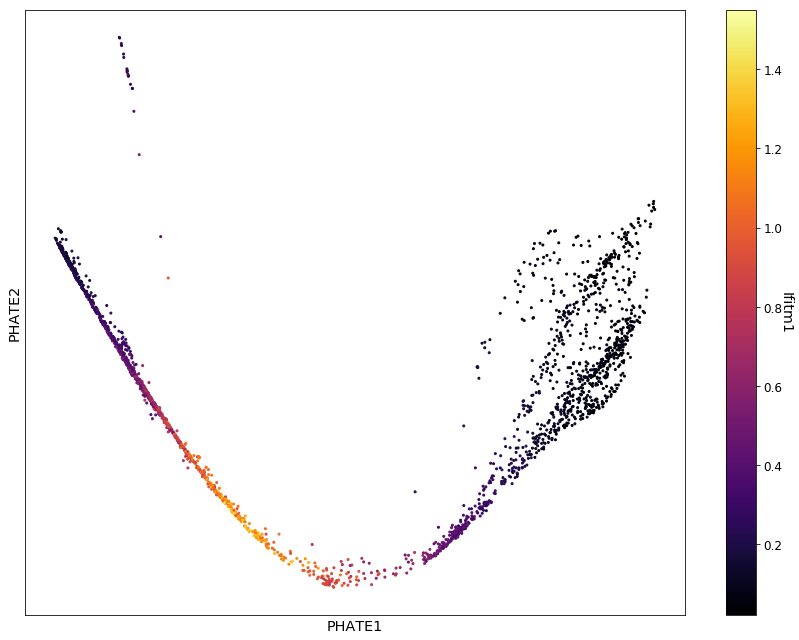

In [19]:
scprep.plot.scatter2d(data_phate, c=bmmsc_magic['Ifitm1'], figsize=(12,9),
                      ticks=False, label_prefix="PHATE", legend_title="Ifitm1")

Note that the structure of the data that we see here is much more subtle than in PCA. We see multiple branches at both ends of the trajectory. To learn more about PHATE, visit <https://phate.readthedocs.io/>.

### Exact vs approximate MAGIC

If we are imputing many genes at once, we can speed this process up with the argument `solver='approximate'`, which applies denoising in the PCA space and then projects these denoised principal components back onto the genes of interest. Note that this may return some small negative values. You will see below, however, that the results are largely similar to exact MAGIC.

In [21]:
approx_magic_op = magic.MAGIC(solver="approximate")
approx_bmmsc_magic = approx_magic_op.fit_transform(bmmsc_data, genes='all_genes')

Calculating MAGIC...
  Running MAGIC on 2416 cells and 10782 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.97 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.72 seconds.
    Calculating affinities...
    Calculated affinities in 0.73 seconds.
  Calculated graph and diffusion operator in 7.58 seconds.
  Calculating imputation...
  Calculated imputation in 0.03 seconds.
Calculated MAGIC in 8.77 seconds.


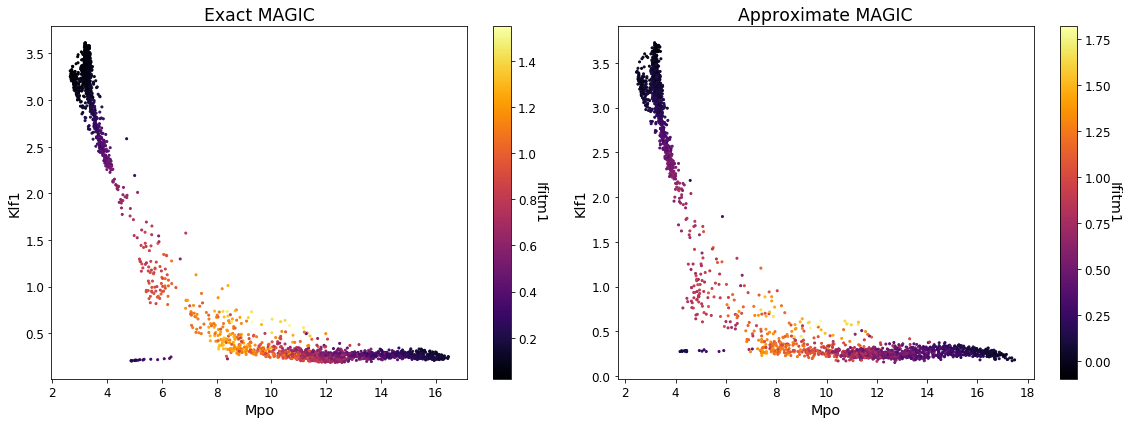

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

scprep.plot.scatter(x=bmmsc_magic['Mpo'], y=bmmsc_magic['Klf1'], c=bmmsc_magic['Ifitm1'],  ax=ax1,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='Exact MAGIC')

scprep.plot.scatter(x=approx_bmmsc_magic['Mpo'], y=approx_bmmsc_magic['Klf1'], c=approx_bmmsc_magic['Ifitm1'], ax=ax2,
                    xlabel='Mpo', ylabel='Klf1', legend_title="Ifitm1", title='Approximate MAGIC')

plt.tight_layout()
plt.show()

### Animating the MAGIC smoothing process

To visualize what it means to set `t` in MAGIC, we can plot an animation of the smoothing process, from raw to imputed values. Below, we show an animation of _Mpo_, _Klf1_ and _Ifitm1_ with increasingly more smoothing.

In [22]:
magic.plot.animate_magic(bmmsc_data, gene_x="Mpo", gene_y="Klf1", gene_color="Ifitm1",
                         operator=magic_op, t_max=10)

### Using the MAGIC smoothed data in downstream analysis
<a id="postprocess"></a>

Finally, if you wish to use the full smoothed matrix in any downstream analysis, you can extract it with the keyword `genes="all_genes"`. Note that this matrix may be very large.

In [23]:
bmmsc_magic = magic_op.transform(genes="all_genes")
bmmsc_magic.head()

,0610007C21Rik;Apr3,0610007L01Rik,0610007P08Rik;Rad26l,0610007P14Rik,0610007P22Rik,0610009B22Rik,0610009D07Rik,0610009O20Rik,0610010F05Rik;mKIAA1841;Kiaa1841,0610010K14Rik;Rnasek,...,mKIAA1632;5430411K18Rik,mKIAA1994;Tsc22d1,mSox5L;Sox5,mTPK1;Tpk1,mimp3;Igf2bp3;AK045244,rp9,scmh1;Scmh1,slc43a2;Slc43a2,tsec-1;Tex9,tspan-3;Tspan3
W31106,0.151034,0.474136,0.047094,0.325711,0.023905,0.049789,0.072632,0.154508,0.028462,1.041323,...,0.034131,0.061556,0.001046,0.004003,0.021676,0.812781,0.169428,0.109237,0.034973,0.217013
W31107,0.129477,0.404013,0.127858,0.398186,0.040590,0.081203,0.126627,0.399529,0.037833,1.002291,...,0.121163,0.605908,0.008875,0.038382,0.008930,1.370542,0.187735,0.012971,0.067375,0.100586
W31108,0.126055,0.532555,0.065157,0.363223,0.021407,0.053234,0.055159,0.182661,0.042069,1.033027,...,0.045135,0.093822,0.000427,0.006537,0.022221,0.902141,0.207225,0.134911,0.039129,0.199574
W31109,0.116920,0.395190,0.117618,0.372115,0.036914,0.068293,0.097169,0.386592,0.032424,1.026546,...,0.107032,0.584393,0.010320,0.034854,0.007795,1.375573,0.191583,0.011704,0.062374,0.084856
W31110,0.134981,0.458598,0.044516,0.343844,0.022056,0.050254,0.052368,0.160224,0.027096,0.985520,...,0.036840,0.108876,0.001780,0.005048,0.016479,0.850539,0.175004,0.113828,0.036142,0.204830


If you wish to export the data, you can do so in many different ways. We recommend the `feather` format, which is fast and lightweight, but `csv` is more commonly used and is compatible with many more software packages.

In [ ]:
!pip install --user feather-format

In [ ]:
import feather
feather.write_dataframe(bmmsc_magic, "bmmsc_magic.feather")

In [ ]:
bmmsc_magic.to_csv("bmmsc_magic.csv")